In [18]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

from  vkitti_dataloader import SequentialImageVirtualKittiDataset
from  vkitti_dataloader import Preprocess


import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.distributions.dirichlet import Dirichlet
from torch.distributions.categorical import Categorical
import torch.nn.functional as F

import segmentation_models_pytorch as smp


import evidence_loss
import epipolar_geometry

In [15]:
IMG_SIZE = 256
old_k = np.array([[725.0087, 0, 620.5],
                   [0, 725.0087, 187],
                   [0, 0, 1]])

K = np.array([[725.0087*(IMG_SIZE/1242), 0, IMG_SIZE/2],
                   [0, 725.0087*(IMG_SIZE/375), IMG_SIZE/2],
                   [0, 0, 1]])

Kinv= np.linalg.inv(K)

print (K)
print (Kinv)

print (K)
print (Kinv)
epipolar_propagation = epipolar_geometry.EpipolarPropagation(K, 
                                           Kinv, 
                                           IMG_SIZE, 
                                           IMG_SIZE, 
                                           fill_empty_with_ones=True)
epipolar_propagation.cuda()

[[149.43818615   0.         128.        ]
 [  0.         494.93927253 128.        ]
 [  0.           0.           1.        ]]
[[ 0.00669173  0.         -0.85654145]
 [ 0.          0.00202045 -0.25861759]
 [ 0.          0.          1.        ]]
[[149.43818615   0.         128.        ]
 [  0.         494.93927253 128.        ]
 [  0.           0.           1.        ]]
[[ 0.00669173  0.         -0.85654145]
 [ 0.          0.00202045 -0.25861759]
 [ 0.          0.          1.        ]]
cuda


EpipolarPropagation()

In [5]:
kornia_transform = Preprocess(resize_shape=64)
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/'

valid_dataset = SequentialImageVirtualKittiDataset(root, "valid", transforms=kornia_transform)

train_dataset = SequentialImageVirtualKittiDataset(root, "train", transforms=kornia_transform)

loaders = {
    "train": DataLoader(train_dataset, batch_size=1, shuffle=True, 
                        num_workers=int(16/2), persistent_workers=True, pin_memory=True), 
    "valid": DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=int(16/2)),
}
print (len(train_dataset), len(valid_dataset))

Found 16968 2 single images sequences
Selecting 16968 two image sequences for mode valid
Total classes  7
Total classes  [1 2 3 4 5 0 6]
Found 25452 2 single images sequences
Selecting 25452 two image sequences for mode train
Total classes  7
Total classes  [1 2 3 4 5 0 6]
25452 16968


In [31]:
DEVICE='cuda'
model = torch.load('/home/deebuls/Documents/phd/blender-dataset/multi-view-fusion-initial/vkitti_cluster_trained.pt')
conv_1d = torch.nn.Sequential(
                          torch.nn.Conv2d(in_channels=2*7, 
                                       out_channels=7, 
                                       kernel_size=3, 
                                       device='cuda'),
                         torch.nn.Upsample(size=(256,256), mode = 'nearest') #Make the image size auto
                        )               

model.to(DEVICE)
              
#Freezing the network
model.eval()
for param in model.parameters():
    param.requires_grad = False
    
optimizer=torch.optim.Adam( conv_1d.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = evidence_loss.edl_mse_loss

In [33]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(loaders['valid'], 0):
        
        # get the inputs; data is a list of [inputs, labels]
        # zero the parameter gradients
        optimizer.zero_grad()
        
        logits_mask0 = model(batch["image0"].to(DEVICE))
        propagate_mask0 = epipolar_propagation(logits_mask0, 
                                                     batch['depth0']/100,
                                                     batch['translation_0_to_1_camera_frame'],
                                                     batch['rotation_0_to_1_camera_frame'])
        
        logits_mask1 = model(batch["image1"].to(DEVICE))
      
        fused_mask = torch.concat((propagate_mask0,logits_mask1), dim=1)
        fused_mask = conv_1d(fused_mask)

        logits_mask0 = F.relu(logits_mask0) + 1
        propagate_mask0 = F.relu(propagate_mask0) + 1
        logits_mask1 = F.relu(logits_mask1) + 1

        

        fused_mask = fused_mask.permute(0,2,3,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        fused_mask = fused_mask.reshape(-1, 7)
        mask = torch.ravel(batch["mask1"])
        # [batch_size*height*width] -> [batch_size*height*width, n_classes] 
        mask = F.one_hot(mask.to(torch.long), 7)
        loss = criterion(fused_mask, mask, epoch, 7, 5)
        #self.log(f"evidential_loss", loss, prog_bar=True)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            

print('Finished Training')    

[1,  2000] loss: 0.345
Finished Training


tensor([1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000, 59.9773,  1.0000],
       device='cuda:0')
logits_mask1  tensor(125.8344, device='cuda:0') tensor(1., device='cuda:0') tensor(4.3509, device='cuda:0')
uncertainty  tensor(1., device='cuda:0') tensor(0.0133, device='cuda:0') tensor(0.1258, device='cuda:0')
fuse tensor(519.8951, device='cuda:0') tensor(1., device='cuda:0') tensor(13.2270, device='cuda:0')


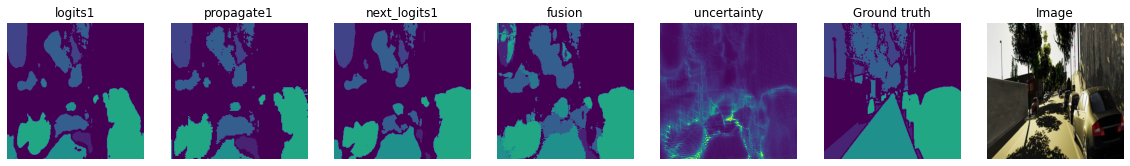

In [34]:
batch = next(iter(loaders['valid']))
bs, num_channels, height, width = batch["image0"].size()
with torch.no_grad():
    model.eval()
    model.cuda()
    logits_mask0 = model(batch["image0"].to(DEVICE))
    propagate_mask0 = epipolar_propagation(logits_mask0, 
                                                 batch['depth0']/100,
                                                 batch['translation_0_to_1_camera_frame'],
                                                 batch['rotation_0_to_1_camera_frame'])

    logits_mask1 = model(batch["image1"].to(DEVICE))

    fused_mask = torch.concat((propagate_mask0,logits_mask1), dim=1)
    fused_mask = conv_1d(fused_mask)

    logits_mask0 = F.relu(logits_mask0) + 1
    propagate_mask0 = F.relu(propagate_mask0) + 1
    logits_mask1 = F.relu(logits_mask1) + 1
    #logits_mask0 = F.relu(logits_mask0) +1
    #propagate_mask0= F.relu(propagate_mask0) +1
    #logits_mask1 = F.relu(logits_mask1) +1
    fused_mask = F.relu(fused_mask) +1
    
    uncertainty = 7 / torch.sum(fused_mask, dim=1, keepdim=True)

    
print (logits_mask0[0,:,250,150])
print (propagate_mask0[0,:,250,150])
print (logits_mask1[0,:,250,150])
print ('logits_mask1 ', logits_mask1.max(), logits_mask1.min(), logits_mask1.mean())
print ('uncertainty ', uncertainty.max(), uncertainty.min(), uncertainty.mean())
print ('fuse', fused_mask.max(), fused_mask.min(), fused_mask.mean())
for logits1, propagate1, next_logits1, f, u, gt_mask, img in zip(torch.argmax(logits_mask0, dim=1, keepdim=True), 
                                   torch.argmax(propagate_mask0, dim=1, keepdim=True), 
                                   torch.argmax(logits_mask1, dim=1, keepdim=True),
                                   torch.argmax(fused_mask, dim=1, keepdim=True),   
                                    uncertainty,
                                   batch['mask1'],
                                   batch['image0']):

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 7, 1)
    plt.imshow(logits1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("logits1")
    plt.axis("off")

    plt.subplot(1, 7, 6)
    plt.imshow(gt_mask.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")
    
    plt.subplot(1, 7, 7)
    img=img.permute(1,2,0)
    plt.imshow(img.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 7, 2)
    plt.imshow(propagate1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("propagate1")
    plt.axis("off")
  
    plt.subplot(1, 7, 3)
    plt.imshow(next_logits1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("next_logits1")
    plt.axis("off")
    
    plt.subplot(1, 7, 4)
    plt.imshow(f.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("fusion")
    plt.axis("off")
    
    plt.subplot(1, 7, 5)
    plt.imshow(u.detach().cpu().numpy().squeeze(), vmin=0, vmax=1) # just squeeze classes dim, because we have only one class
    plt.title("uncertainty")
    plt.axis("off")
  
    #plt.savefig('result.png')
    plt.show()
    
del batch, logits_mask0, propagate_mask0, logits_mask1 , fused_mask, uncertainty, img